<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<font color="#138D75">**WEkEO Training**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Anna-Lena Erdmann (EUMETSAT)

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://jupyterhub.prod.wekeo2.eu/hub/user-redirect/lab/tree/public/wekeo4data/wekeo-eocanvas/EOCanvasWorkflow_Extract_Pixel_Values.ipynb"><img src="https://img.shields.io/badge/launch-WEKEO-1a4696.svg?style=flat&logo=" alt="Open in WEkEO"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>    
</html>

<div class="alert alert-block alert-success">
<h3> WEkEO EOCanvas Workflows - Applied Examples of EOCanvas for your EO Data Processing</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
  - **<a href="https://my.wekeo.eu/user-registration" target="_blank">A WEkEO account</a>**
  - basic knowledge of EOCanvas through executing the **<a href="https://github.com/wekeo/wekeo4data/blob/main/wekeo-eocanvas/01_Introduction_to_EOCanvas.ipynb" target="_blank">EOCanvas Introduction Notebook</a>**
  

</div>
<hr>

# Extraction of Pixel Values from a Sentinel-3 Satellite Image

### Learning outcomes

At the end of this notebook, you will know:

* how to how to extract the picel values using EOCanvas
* how to modify the EOCanvas workflow to extract values from custom locations
* how to visualize the extracted values on a map


### Outline

This notebook demonstrates how to access and process Sentinel-3 OLCI satellite imagery to extract pixel values for point sampling using the WEkEO EOCanvas. The sampling of pixel values is specifically useful for the generation of machine learning training datasets or for creating time series of a single point. 

<div class="alert alert-info" role="alert">

### Contents <a id='totop'></a>

</div>
    
 1. [Setting Up](#section0)
 2. [Retrieval of the Satellite Image](#section1)
 3. [Import / Define your sampling points](#section2)
 4. [Adapt the SNAP Graph with your sampling points](#section3)
 5. [Pixel Extraction using EOCanvas](#section4)
 6. [Postprocessing and visualizing the result](#section5)

<hr>

<div class="alert alert-info" role="alert">

## 1. <a id='section0'></a>Setting up
[Back to top](#totop)
    
</div>

Load necessary modules:

In [29]:
from eocanvas import API, Credentials
from eocanvas.api import Input, Config, ConfigOption
from eocanvas.processes import SnapProcess
from eocanvas.snap.graph import Graph

from hda import Client

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


You must replace `<your_user_name>` and `<your_password>` with the information from your WEkEO account (if you don't have one yet, register <a href="https://www.wekeo.eu/" target="_blank">here</a>.

Save your credentials. They will be automatically loaded when required.

In [3]:
c = Credentials(username="<your_user_name>", password="<your_password>")
c.save()

Credentials are written to file C:\Users\erdmann\.hdarc


<div class="alert alert-info" role="alert">

## 2. <a id='section1'></a>Retrieval of the Satellite Image
[Back to top](#totop)
    
</div>

In this section, we retrieve a **Sentinel-3 satellite image tile** as our input. For more information on this dataset, refer to the [WEkEO data description](https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_2_WFR___).

For simplicity, we are using a single tile in this example. For information on handling multiple tiles, refer to **Section XX**.


**Search for the Tile**: We conduct a search through the WEkEO Harmonized Data Access (HDA) API, specifying our desired parameters to locate a single Sentinel-3 image. For further details on creating API requests, see the [WEkEO API notebook](https://github.com/wekeo/wekeo4data/blob/main/wekeo-hda/wekeo_harmonised_data_access_api.ipynb).

In [4]:
q = {
  "dataset_id": "EO:EUM:DAT:SENTINEL-3:OL_2_WFR___",
  "dtstart": "2024-07-22T15:40:00.000Z",
  "dtend": "2024-07-22T15:43:00.000Z",
  "publication": "2021-12-20T09:47:29.021Z",
  "bbox": [
    -83.65525712228973,
    27.03509268442863,
    -80.56304425603494,
    30.55352332370563
  ],
  "sat": "Sentinel-3B",
  "type": "OL_2_WFR___",
  "timeliness": "NT",
  "relorbit": "282",
  "cycle": "95"
}

c = Client()

**Retrieve the Result**: The search will return one result matching our criteria.

In [6]:
r = c.search(q)
r

SearchResults[items=1,volume=519.2MB]

**Obtain Download URL**: The URL of the result will be used as input for EOCanvas processing functions.

In [7]:
url = r.get_download_urls()[0]
url

'https://gateway.prod.wekeo2.eu/hda-broker/api/v1/dataaccess/download/6720c86252f25514612c2465'

<div class="alert alert-info" role="alert">

## 3. <a id='section2'></a>Import / Define your sampling points
[Back to top](#totop)
    
</div>

In this cell, we set up the **location data** where we plan to sample satellite images. 


1. **Data Format**: Locations for sampling need to be converted to a **Pandas DataFrame**.

2. **Required Parameters**:
   - `id`: A unique identifier for each location.
   - `lat`: Latitude of the location.
   - `lon`: Longitude of the location.
   - `time`: Timestamp specifying the date and time for each location.



3. **Defining Locations**:
   - **Direct Definition**: As shown in this example, you can define the locations within the code by creating a dictionary and converting it to a DataFrame.
   - **Loading from a File**: Alternatively, if you have location data saved in a file (e.g., `.csv` or `.txt`), you can load it into a DataFrame using the `pd.read_csv()` function.


In [9]:
import pandas as pd
import xml.etree.ElementTree as ET

# Example DataFrame with coordinates, times, and ids
data = {
    'id': [0, 1, 2],
    'lat': [27.8931, 28.225, 28.123],
    'lon': [-82.9425, -82.6725, -82.523],
    'time': ['2024-07-22T08:31:00', '2024-07-22T08:31:00', '2024-07-22T08:31:00']
}

# Create a DataFrame
df = pd.DataFrame(data)
df


,id,lat,lon,time
0,0,27.8931,-82.9425,2024-07-22T08:31:00
1,1,28.2250,-82.6725,2024-07-22T08:31:00
2,2,28.1230,-82.5230,2024-07-22T08:31:00


<div class="alert alert-info" role="alert">

## 4. <a id='section3'></a>Adapt the SNAP Graph with your sampling points
[Back to top](#totop)
    
</div>

**EOCanvas** uses workflows from existing geospatial software. Here, we leverage **SNAP** (the [Sentinel Application Platform](https://step.esa.int/main/toolboxes/snap/)), a toolbox for processing satellite data.
A pre-prepared **SNAP graph** for pixel extraction is provided, but it needs to be customized to include our sample locations.

The graph is stored in `input_graphs/extractpix.xml`. We read the graph using the `ET.parse()` function


In [10]:
# Load the existing XML file
tree = ET.parse('input_graphs/extractpix.xml')  # Replace with the path to your existing XML file
root = tree.getroot()


Use the structure of the XML file to add the locations from the DataFrame to the graph. The coordinated need to be inserted in the xml section `"coordinates"`. 

For each of the defined coordinates, we insert the required fields as SubElements in the SNAP graph. 

In [11]:
# Find the <parameters> element where coordinates should be added.
# Adjust this search based on the structure of your XML.

for node in root.findall(".//node"):
    parameters = node.find("parameters")
    if parameters is not None:
        # Find or create the <coordinates> element within <parameters>
        coordinates = parameters.find("coordinates")
        if coordinates is None:
            coordinates = ET.SubElement(parameters, "coordinates")

        # Add each coordinate as a new <coordinate> element
        for idx, row in df.iterrows():
            coordinate = ET.SubElement(coordinates, "coordinate")
            ET.SubElement(coordinate, "name").text = f"Coord_{idx}"
            ET.SubElement(coordinate, "latitude").text = str(row['lat'])
            ET.SubElement(coordinate, "longitude").text = str(row['lon'])
            ET.SubElement(coordinate, "dateTime").text = row['time']
            ET.SubElement(coordinate, "originalValues")
            ET.SubElement(coordinate, "id").text = str(row['id'])


After the adjustment, the xml graph looks like this. Note, that we find out three defined coordinated inside the Graph. 

```xml
<graph id="pixExGraph">
    <version>1.0</version>
    <node id="someNodeId">
        <operator>PixEx</operator>
        <parameters>
            <sourceProductPaths>$img1</sourceProductPaths>
            <exportBands>true</exportBands>
            <exportTiePoints>true</exportTiePoints>
            <exportMasks>false</exportMasks>
            <coordinates>
                <coordinate>
                    <name>Coord_0</name>
                    <latitude>27.8931</latitude>
                    <longitude>-82.9425</longitude>
                    <dateTime>2024-07-22T08:31:00</dateTime>
                    <originalValues />
                    <id>0</id>
                </coordinate>
                <coordinate>
                    <name>Coord_1</name>
                    <latitude>28.225</latitude>
                    <longitude>-82.6725</longitude>
                    <dateTime>2024-07-22T08:31:00</dateTime>
                    <originalValues />
                    <id>1</id>
                </coordinate>
                <coordinate>
                    <name>Coord_2</name>
                    <latitude>28.123</latitude>
                    <longitude>-82.523</longitude>
                    <dateTime>2024-07-22T08:31:00</dateTime>
                    <originalValues />
                    <id>2</id>
                </coordinate>
            </coordinates>
            <timeDifference>1D</timeDifference>
            <windowSize>1</windowSize>
            <outputDir>$output</outputDir>
            <outputFilePrefix>pixEx</outputFilePrefix>
            <exportExpressionResult>true</exportExpressionResult>
            <aggregatorStrategyType>no aggregation</aggregatorStrategyType>
            <exportSubScenes>false</exportSubScenes>
            <subSceneBorderSize>0</subSceneBorderSize>
            <exportKmz>false</exportKmz>
            <extractTimeFromFilename>false</extractTimeFromFilename>
            <dateInterpretationPattern>yyyyMMdd</dateInterpretationPattern>
            <filenameInterpretationPattern>*${startDate}*${endDate}*</filenameInterpretationPattern>
            <includeOriginalInput>false</includeOriginalInput>
        </parameters>
    </node>
</graph>

We save the modified graph and use it later as input to the EOCAnvas function. 

In [22]:
# Write the modified XML back to a file
tree.write('input_graphs/extractpix_florida.xml', encoding='utf-8', xml_declaration=True)

print("XML file updated: extractpix_florida.xml")

XML file updated: extractpix_florida.xml


<div class="alert alert-info" role="alert">

## 5. <a id='section4'></a>Pixel Extraction using EOCanvas
[Back to top](#totop)
    
</div>


To process data using the EOCAnvas Serverless Functions, there are **three necessary inputs** to provide to the function:

 1. Data
 2. Processing Workflow: the SNAP Graph
 3. Configuration Parameters

The three inputs are defined in the cell below.

In [40]:
data = Input(key="img1", url=url)
graph = Graph.from_uri("input_graphs/extractpix_florida.xml")
config = Config(key="img1", options=ConfigOption(uncompress=True, sub_path="xfdumanifest.xml"))

Next, we create and run the process, that will execute the SNAP graph on the Sentinel-3 satellite scene. 

In [41]:
process = SnapProcess(snap_graph=graph, eo_config=config, eo_input=data)

In [43]:
process.run(download_dir="result/pixex")

Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: accepted at 2024-10-10T10:10:31.861642
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:10:42.414449
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:10:53.929729
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:11:06.572862
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:11:20.875540
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:11:36.202546
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:11:53.003799
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:12:11.230917
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:12:31.226596
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:12:53.176377
Job: 65b77143-6eee-525d-921e-d30872c56644 - Status: running at 2024-10-10T10:13:17.269315




<div class="alert alert-info" role="alert">

## 6. <a id='section5'></a>Post Processing and visualizing the result
[Back to top](#totop)
    
</div>


In this code cell, we are loading the measurement results from a text file generated by the pixel extraction process. 

- The file is located at `'result/pixex/pixEx_OL_2_WFR_measurements.txt'` within the `result` folder.
- We use the `pd.read_csv` function from the pandas library to read the file, skipping any header lines (denoted by the `#` comment character).

This allows us to create a DataFrame `df` that will contain the sampled data for further analysis or visualization.

In [23]:
# Read the result 
file_path = 'result/pixex\pixEx_OL_2_WFR_measurements.txt'
df = pd.read_csv(file_path, sep='\t', comment='#')

Each row corresponding to a specific coordinate and each column representing a different band from the OLCI satellite scene. The reflectance bands, as well as the flags and auxiliary informations were sampled, which is why we have a large number (**174**) of columns in the dataframe. 

In [27]:
df

,ProdID,CoordID,Name,Latitude,Longitude,PixelX,PixelY,Date(yyyy-MM-dd),Time(HH_mm_ss),Oa01_reflectance,...,atmospheric_temperature_profile_pressure_level_22,atmospheric_temperature_profile_pressure_level_23,atmospheric_temperature_profile_pressure_level_24,atmospheric_temperature_profile_pressure_level_25,horizontal_wind_vector_1,horizontal_wind_vector_2,humidity,sea_level_pressure,total_columnar_water_vapour,total_ozone
0,0,1,Coord_0,27.894343,-82.942737,2652.5,938.5,2024-07-22,15:40:27,-0.002881,...,241.287216,255.254364,256.791656,257.645294,0.142770,1.299098,71.442101,1017.313049,50.102245,0.006323
1,0,2,Coord_1,28.225352,-82.673096,2720.5,797.5,2024-07-22,15:40:21,NaN,...,241.420044,254.463913,257.451538,257.348541,0.014110,-0.762837,75.395805,1017.234802,49.588882,0.006332
2,0,3,Coord_2,28.123321,-82.521972,2783.5,824.5,2024-07-22,15:40:22,NaN,...,241.551300,254.805389,256.936920,257.621063,-0.998073,-0.209238,74.389458,1017.175171,48.377071,0.006335


We can select only the necessary information (bands) from the dataframe and visulaize it on a map. 

In [ ]:
# Convert the necessary columns to appropriate types
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['CHL_NN'] = pd.to_numeric(df['CHL_NN'], errors='coerce')

In [30]:
# convert to a geodataframe
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude'])
)

# Set the coordinate reference system (CRS)
gdf=gdf.set_crs(epsg=4326, inplace=True)



When we now plot the Chlorophyll Values (`CHL_NN`) of the map, we only see one point. Two of the coordinated are missing. **Missing values** are cuased by flagging of the measurements, e.g. because of cloud cover, locations on land or a unsufficient measurement quality.  

C:\Users\erdmann\AppData\Local\Temp\ipykernel_10288\2510532734.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


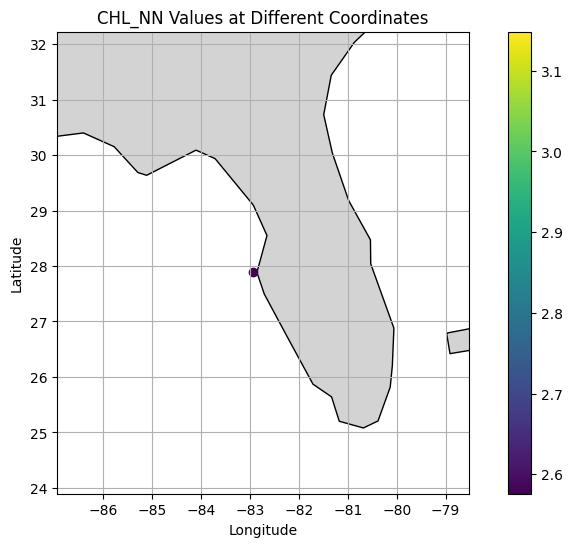

In [31]:
# Create a plot with a background map using the 'world' map from geopandas datasets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
ax = world.plot(figsize=(10, 6), color='lightgray', edgecolor='black')
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-4, maxx+4)
ax.set_ylim(miny-4, maxy+4)

# Plot the points with CHL_NN values
gdf.plot(
    ax=ax,
    column='CHL_NN',  # Color points based on CHL_NN values
    legend=True,
    cmap='viridis'   # Colormap (e.g., 'viridis', 'plasma', 'coolwarm')

)

plt.title('CHL_NN Values at Different Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()
